## 1. Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from sklearn.datasets import load_iris

Using TensorFlow backend.


## 2. UDF

### 2.0 PCA Color Augmentation function

In [2]:
# PCA Color Augmentation function
def pca_color_augmentation_tensor(inputs, std_deviation=0.1, scale=1.0, clipping=True):
    ranks = inputs.ndim
    assert ranks >= 2
    
    chs = inputs.shape[-1]

    # swapaxis, reshape for calculating covariance matrix
    # rank 2 = (batch, dims)
    # rank 3 = (batch, step, dims)
    if ranks <= 3:
        x = inputs.copy()
    # rank 4 = (batch, height, width, ch) -> (batch, dims, ch)
    elif ranks == 4:
        dims = inputs.shape[1] * inputs.shape[2]
        x = inputs.reshape(-1, dims, chs)
    # rank 5 = (batch, D, H, W, ch) -> (batch, D, dims, ch)
    elif ranks == 5:
        dims = inputs.shape[2] * inputs.shape[3]
        depth = inputs.shape[1]
        x = inputs.reshape(-1, depth, dims, chs)

    # scaling-factor
    calculate_axis, reduce_axis = ranks-1, ranks-2
    if ranks == 3:
        calculate_axis, reduce_axis = 1, 2
    elif ranks >= 4:
        calculate_axis, reduce_axis = ranks-3, ranks-2
    C = 1.0
    if ranks >= 3:
        C = x.shape[reduce_axis]
    var = np.var(x, axis=calculate_axis, keepdims=True)
    scaling_factors = np.sqrt(C / np.sum(var, axis=reduce_axis, keepdims=True))
    # scaling
    x = x * scaling_factors

    # subtract mean for cov matrix
    mean = np.mean(x, axis=calculate_axis, keepdims=True)
    x -= mean

    # covariance matrix
    cov_n = max(x.shape[calculate_axis] - 1, 1)
    # cov (since x was normalized)
    cov = np.matmul(np.swapaxes(x, -1, -2), x) / cov_n

    # eigen value(S), eigen vector(U)
    U, S, V = np.linalg.svd(cov)
    # eigen_values vs eigen_vectors
    # rank = 2 : (dims) vs (dims, dims)
    # rank = 3 : (batch, dims) vs (batch, dims, dims)
    # rank = 4 : (batch, ch) vs (batch, ch, ch)
    # rank = 5 : (batch, D, ch) vs (batch, D, ch, ch)

    # random values
    # if rank2 : get differnt random variable by sample
    if ranks == 2:
        rand = np.random.randn(*inputs.shape) * std_deviation
        delta = np.matmul(rand*np.expand_dims(S, axis=0), U)
    else:
        rand = np.random.randn(*S.shape) * std_deviation
        delta_original = np.squeeze(np.matmul(U, np.expand_dims(rand*S, axis=-1)), axis=-1)

    # adjust delta shape
    # rank = 3 : (batch, dims) -> (batch, 1[step], dims)
    # rank = 4 : (batch, ch) -> (batch, 1[ndim], ch)
    # rank = 5 : (batch, D, ch) -> (batch, D, 1[ndim], ch)
    if ranks == 3:
        delta = np.expand_dims(delta_original, axis=ranks-2)
    elif ranks >= 4:
        delta = np.expand_dims(delta_original, axis=ranks-3)
        # reshape to original input shape(if rank >= 4)
        # rank = 4 : (batch, ndim, ch) -> (batch, height, width, ch)
        # rank = 5 : (batch, D, ndim, ch) -> (batch, D, height, width, ch)
        delta = np.broadcast_to(delta, x.shape)
        delta = delta.reshape(-1, *inputs.shape[1:])

    # delta scaling
    delta = delta * scale

    #print("scaling factor", scaling_factors.shape)
    #print("mean", mean.shape)
    #print("cov", cov.shape)
    #print("S", S.shape)
    #print("U", U.shape)
    #print("rand", rand.shape)
    #print("delta", delta.shape)

    # clipping (if clipping=True)
    result = inputs + delta
    if clipping:
        result = np.clip(result, 0.0, scale)

    return result


### 2.1 Dataset Specific Functions

In [3]:
# PCA color augmentation for cifar dataset
def demo_cifar_tensor():
    (_, _), (X, _) = cifar10.load_data()
    X = X / 255.0

    aug = pca_color_augmentation_tensor(X[:100])

    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
    for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        ax.imshow(aug[i])
        ax.axis("off")
    plt.show()

# PCA Color Augmentation for structured data
def demo_iris_tensor():
    data = load_iris()
    X = data["data"]

    X_aug = pca_color_augmentation_tensor(X, clipping=False)

    indices = np.arange(X.shape[0])
    cm = plt.get_cmap("Set1")
    plt.figure(figsize=(8,8))
    for i in range(X.shape[1]):
        ax = plt.subplot(2, 2, i+1)
        ax.plot(indices, X_aug[:,i], ".", color=cm(i))
        ax.set_title(data["feature_names"][i])
    plt.show()

    
# Categorical data augmentation can be done!
def demo_iris_categorical():
    data = load_iris()
    # Reshape by category
    X = data["data"].reshape(3, 50, 4)
    # Categorical data augmentation and reshape to the original shape
    X_aug = pca_color_augmentation_tensor(X, clipping=False).reshape(-1, 4)

    indices = np.arange(X_aug.shape[0])
    cm = plt.get_cmap("Set1")
    plt.figure(figsize=(8,8))
    for i in range(X_aug.shape[1]):
        ax = plt.subplot(2, 2, i+1)
        ax.plot(indices, X_aug[:,i], ".", color=cm(i))
        ax.set_title(data["feature_names"][i])
    plt.show()

## 3. Color Augmentated Images

170500096/170498071 [==============================] - 4s 0us/step


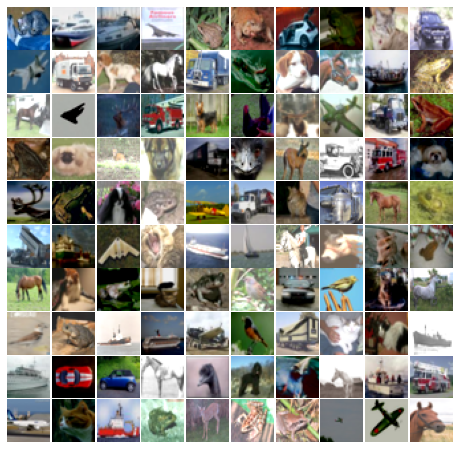

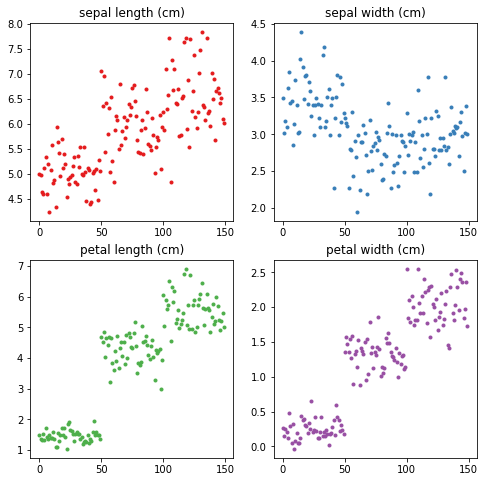

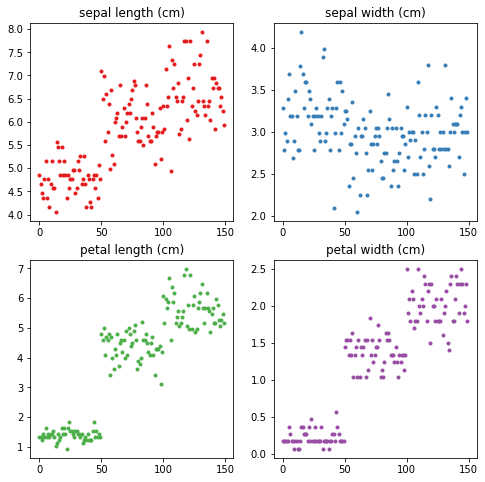

In [4]:
if __name__ == "__main__":
    demo_cifar_tensor()
    demo_iris_tensor()
    demo_iris_categorical()

* TensorFlow's GPU SVD is too slow, so better to use this CPU numpy version.